# Example: Smart Daily Bollinger Bands Autotrade Agent
In this example, we will explore an auto trade strategy similar to [Bollinger Bands](https://www.bollingerbands.com/) that computes a decision boundary based upon a region around a moving average. The basis of this approach is mean-reversion: if the share price is below the lower boundary, we have a potential buy signal; if it is above the upper boundary, we have a sell signal.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [1]:
include("Include.jl");

## Prerequisites: Constants and process the aggregate share price data
Before setting up the simulation, we load and process the out-of-sample daily aggregate share price data for members of the list of [SP500 firms](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) from `01-03-2024` to `12-04-24`. Then, we set some constant values that we'll use throughout the rest of the notebook. In particular, in the `prerequisites` code block, we will:
* First, we'll load the out-of-sample data and remove tickers that do not have the maximum number of trading days. We'll store the cleaned data in the `dataset::Dict{String, DataFrame}` variable.
* Next, we'll get a list of all the tickers in the `dataset,` sort them alphabetically, and store them in the `all_tickers_array` variable.
* Finally, we'll set some constants that we'll use later in the study.

In [5]:
original_dataset = MyOutOfSamepleMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL,` and save that value in the `maximum_number_trading_days` variable:

In [9]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

* Second, let's iterate through our data and collect only those tickers with `maximum_number_trading_days::Int64` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [14]:
dataset = let
    dataset = Dict{String,DataFrame}();
    for (ticker,data) ∈ original_dataset
        if (nrow(data) == maximum_number_trading_days)
            dataset[ticker] = data;
        end
    end
    dataset
end

Dict{String, DataFrame} with 482 entries:
  "TPR"  => 206×8 DataFrame…
  "EMR"  => 206×8 DataFrame…
  "CTAS" => 206×8 DataFrame…
  "HSIC" => 206×8 DataFrame…
  "KIM"  => 206×8 DataFrame…
  "PLD"  => 206×8 DataFrame…
  "IEX"  => 206×8 DataFrame…
  "BAC"  => 206×8 DataFrame…
  "CBOE" => 206×8 DataFrame…
  "EXR"  => 206×8 DataFrame…
  "NCLH" => 206×8 DataFrame…
  "CVS"  => 206×8 DataFrame…
  "DRI"  => 206×8 DataFrame…
  "DTE"  => 206×8 DataFrame…
  "ZION" => 206×8 DataFrame…
  "AVY"  => 206×8 DataFrame…
  "EW"   => 206×8 DataFrame…
  "EA"   => 206×8 DataFrame…
  "NWSA" => 206×8 DataFrame…
  "BBWI" => 206×8 DataFrame…
  "CAG"  => 206×8 DataFrame…
  "GPC"  => 206×8 DataFrame…
  "FCX"  => 206×8 DataFrame…
  "GILD" => 206×8 DataFrame…
  "UNP"  => 206×8 DataFrame…
  ⋮      => ⋮

* Lastly, let's get a list of firms in the cleaned-up `dataset::Dict{String, DataFrame},` sort the list alphabetically, and save it in the `list_of_all_tickers` array:

In [18]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

### Constants
Before moving on, let's specify some constants we'll use later. Please take a look at the comments following the value to describe what it is, its permissible values, units, etc.

In [25]:
number_of_trading_periods = maximum_number_trading_days; # how many days of 2024 data do we have?
start_trading_index = 1; # What trading day index will we start at? (≥ 1)
length_of_autotrading_run = maximum_number_trading_days - 1; # number of trading days
start_index = 1;  # index to start viewing the data. This value needs to >= 1
stop_index = start_index + length_of_autotrading_run; # index where we stop viewing the data. This value needs to be <= to number_of_trading_periods
view_range = range(start_index, stop = stop_index, step = 1) |> collect; # view_range is the range we use to look at (simulate) the data
initial_budget = 1000.0; # initial budget of the agent
θ = 0.05; # if we do sell, how much do we sell (fraction of current shares to sell)
γ = 0.5; # what fraction of the original budget do we invest initially?
my_ticker_of_interest = "DPZ"; # select a ticker

## Task 1: Compute simple moving average trade signals
In this task, we'll compute the simple moving average of the share price of your ticker of interest and develop a decision boundary, which we'll use in the subsequent tasks to formulate a trading policy. We'll use an [incremental simple moving average](https://en.wikipedia.org/wiki/Moving_average) where the average price is updated with new data as the algorithm marches through time. 
Let the typical price in period $\tau$ be given by $S_{\tau}$ (units: `USD/share`) and the moving average of the `tp` at time $\tau$ be given by $\hat{S}_{\tau}$ (units: `USD/share`). 
$$
\begin{equation}
\hat{S}_{\tau} = \hat{S}_{\tau - 1} + \alpha(\tau)\cdot\left(S_{\tau} - \hat{S}_{\tau - 1}\right)
\end{equation}
$$
where $\alpha(\tau)$ is the `learning function`.  The `learning function` controls how much new information is included in the update between $(\tau-1)\rightarrow\tau$. For example, if $\alpha(\tau) = 0$, no new information is added to the updated average estimate. 
* __What value for $\alpha(\tau)$__? A simple moving average computed over a time window of length $\mathcal{L}\geq{1}$ has a `learning function` given by $\alpha(\tau) = \mathcal{L}^{-1}$. Thus, as the window length increases in size, i.e., $\mathcal{L}\rightarrow\infty$, the simple moving average learning rate goes to zero $\alpha(\tau) \rightarrow{0}$. We'll select a $\alpha(\tau)$ value to capture some desired time scale.

Let's specify a constant value for the `learning function` such that $0<\alpha(\tau)<1$, and save it in the `α::Float64` variable. 

In [30]:
α = (1/20); # students can update this!

Next, get the observed share price for the ticker specified in the `my_ticker_of_interest::String` variable from the `dataset::Dict{String, DataFrame}` dictionary. Save the data in the `typical_price_array::Array{Float64,1}` array variable:

In [35]:
typical_price_array = dataset[my_ticker_of_interest][!,:open]; # we can choose different prices here {open | close | high | low | vwap}

Next, using the incremental update expression above, let's compute the moving average. 
* First, we initialize some memory, and next, we initialize the average `mtypical_price_array` series with the `typicalprice` value, in this case, the actual `typicalprice` value. Thus, at the first time step (array index `1`), the `mtypical_price_array = typicalprice.` Then, we compute the moving average using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for).
* For each time step `2 ... number_of_trading_periods`, we use the incremental update expression to compute the average value and store it in the `mtypical_price_array::Array{Float64,1}` array.

In [42]:
mtypical_price_array = let
    
    mtypical_price_array = Array{Float64,1}(undef, number_of_trading_periods);
    mtypical_price_array[1] = typical_price_array[1]; 
    
    for i ∈ 2:number_of_trading_periods
        previous_mtp = mtypical_price_array[i-1];
        current_tp = typical_price_array[i];
        mtypical_price_array[i] = previous_mtp + α*(current_tp - previous_mtp);
    end
    mtypical_price_array;
end;

#### Visualize the MTP
`Unihide` the code block below to see how we plotted the actual and moving average for `daily` aggregates of `my_ticker_of_interest.`
* The `typicalprice` for `my_ticker_of_interest` is shown in the blue-line, while the moving average of the typical price (mtp) is shown by the red-line. The mtp is a smoothed and lagged version of the `typicalprice` with the high-frequency information removed. Thus, it gives a slower picture of the `typicalprice` dynamics. The $\alpha(\tau)$ parameter controls the inclusion of fast or slow dynamics.
* __What is the signifinance of $\alpha(\tau)$__? The parameter $\alpha(\tau)$ represents a time constant measured; when $\alpha(\tau)$ is large, the moving average typical price (mtp) trajectory includes high-frequency data. Conversely, when $\alpha(\tau)$ is small, only slow dynamics or low-frequency information is retained in the mtp. This means that data with a frequency of $\alpha(\tau)$ or below is included in the mtp, while data with a frequency greater than $\alpha(\tau)$ is excluded.

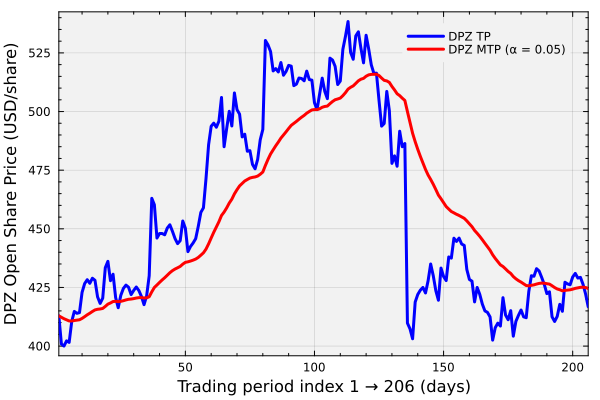

In [47]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, view_range, typical_price_array[view_range],c=:blue, xlims=(first(view_range), last(view_range)), lw=3, 
        label="$(my_ticker_of_interest) TP", xminorticks=5, yminorticks=5)
    plot!(view_range, mtypical_price_array[view_range], c=:red, lw=3, label="$(my_ticker_of_interest) MTP (α = $(round(α, digits=4)))")
    xlabel!("Trading period index $(first(view_range)) → $(last(view_range)) (days)", fontsize=18)
    ylabel!("$(my_ticker_of_interest) Open Share Price (USD/share)", fontsize= 18);
end

### TODO: Develop a _potential_ decision boundary
The moving average typical price (mtp) gives us a reference trajectory to use as a decision boundary, i.e., a `my_ticker_of_interest` price level that we'll use to make `{buy, hold, sell}` decisions. 
* `Hypothesis`: If `typicalprice` < `mtypicalprice,` we'll buy shares as we expect `my_ticker_of_interest` to be oversold, and the price will revert to the `mtypicalprice` value. On the other hand, if `typicalprice` > `mtypicalprice,`  we will sell shares. In this case, we expect that `my_ticker_of_interest` is overbought, and the price will drop to the `mtp` price.

However, let's refine this hypothesis further and add a buffer of size $\pm\,\beta\cdot\sigma$ around the `mtypicalprice` trajectory in which we hold, i.e., do not sell any shares. The multiplier $\beta$ is a user-adjustable hyperparameter, while $\sigma$ is the standard deviation of the `mtypicalprice,` that we calculate next. This is [a similar concept to Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands).

#### Calculate the decision boundary standard deviation
Like the incremental moving average for the share price shown above, suppose the average standard deviation at time step $\tau$ is given by $\hat{\sigma}_{\tau}$. We can incrementally update this value as new data becomes available. By analogy to the price expression, we propose an update rule for the standard deviation, which we'll use in our decision process, of the form:
$$
\begin{equation}
\hat{\sigma}_{\tau} = \hat{\sigma}_{\tau - 1} + \alpha(\tau)\cdot\left(\epsilon_{\tau} - \hat{\sigma}_{\tau - 1}\right)
\end{equation}
$$
where $\alpha(\tau)$ is the `learning function` from above, and $\epsilon_{\tau}$ is the 1-step standard deviation given by the expression:
$$
\begin{equation}
\epsilon_{\tau} = \sqrt{\left(S_{\tau} - \hat{S}_{\tau}\right)^2}
\end{equation}
$$
The $S_{\tau}$ value denotes the typical price at time $\tau$, while the $\hat{S}_{\tau}$ term denotes the moving average typical price (mtp) at time $\tau$. Thus, the $\epsilon_{\tau}$ term measures the residual between the `tp` and the `mtp` price. 
* To implement the moving average calculation, first, we allocate some space for the $\hat{\sigma}_{\tau}$ values in the `decision_boundary_array::Array{Float64,1}` array. We then initialize the first value of this series to zero, i.e., we have complete knowledge of the average price at index `1` because we know that `tp = mtp` at index `1,` thus $\hat{\sigma}_{1} = 0$. Then, we process each time step `2 ... number_of_trading_periods` using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for), where we implement the incremental update expression above and store the result in the `decision_boundary_array::Array{Float64,1}` array.

In [56]:
decision_boundary_array = let
    decision_boundary_array = Array{Float64,1}(undef, number_of_trading_periods);
    decision_boundary_array[1] = 1.0; # hmmmm. what does this do?
    for i ∈ 2:(number_of_trading_periods)
        previous_decision_boundary = decision_boundary_array[i-1];
        ϵ = (typical_price_array[i] - mtypical_price_array[i])^2 |> x -> sqrt(x);
        decision_boundary_array[i] = previous_decision_boundary + α*(ϵ - previous_decision_boundary);
    end
    decision_boundary_array
end;

TODO: Develop a _potential_ decision boundary